In [1]:
# If running in google colab:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
# Download en_core_web_lg for google colab
# !python -m spacy download en_core_web_lg

In [3]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import regex as re
# import unicodedata

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, pairwise_distances

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# KNN used to help determine epsilon value for DBSCAN
from sklearn.neighbors import NearestNeighbors

from sklearn.manifold import TSNE


# import spacy
# import en_core_web_lg
# from spacy.lang.en import English
# from spacy.lang.en.stop_words import STOP_WORDS

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# # Loading the large (sm) spaCy English model, pre-trained on web text data
# # In order to use vectorization, you must use the large pipeline package
# # https://spacy.io/usage/spacy-101
# '''
# "To make them compact and fast, spaCy’s small pipeline packages (all packages that end in sm) 
# don’t ship with word vectors, and only include context-sensitive tensors... 
# So in order to use real word vectors, you need to download a larger pipeline package."
# '''
# nlp = en_core_web_lg.load()

# # max length must be increased due to large size of each document
# nlp.max_length = 10000000 # or higher

In [5]:
# # Importing the finalized concatinated dataframe
# # Use this line if running locally
# data = pd.read_csv('../data/tweet_vectors.csv')

# If running in google colab, use this import line:
# Change to file location if necessary
# data = pd.read_csv('/content/drive/MyDrive/Python/tweet_vectors_1.csv')

data1 = pd.read_json('/content/drive/MyDrive/Python/tweet_vectors_1.json')
data2 = pd.read_json('/content/drive/MyDrive/Python/tweet_vectors_2.json')
data3 = pd.read_json('/content/drive/MyDrive/Python/tweet_vectors_3.json')
data4 = pd.read_json('/content/drive/MyDrive/Python/tweet_vectors_4.json')


In [6]:
# data1.head()



In [7]:
data = pd.concat([data1, data2, data3, data4], axis=0, sort=False)

# data = data.drop_duplicates()

In [8]:
# keeping only certain columns that will be used
columns_keep =['screen_name','state','position','name','party','tweet_count','text_concat_clean','liststring','vectors', 'text_length', 'word_length']

data = data[columns_keep]

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521 entries, 0 to 129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   screen_name        521 non-null    object
 1   state              521 non-null    object
 2   position           521 non-null    object
 3   name               521 non-null    object
 4   party              521 non-null    object
 5   tweet_count        521 non-null    int64 
 6   text_concat_clean  521 non-null    object
 7   liststring         521 non-null    object
 8   vectors            521 non-null    object
 9   text_length        521 non-null    int64 
 10  word_length        521 non-null    int64 
dtypes: int64(3), object(8)
memory usage: 48.8+ KB


In [10]:
# Create X
X = data['vectors']
X = np.matrix(X.tolist())

# Applying the Standard Scaler to word vectors
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Applying PCA to word vectors
# choosing n components
# https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
pca = PCA(n_components = 0.95)
X_pca = pca.fit_transform(X)

# Applying standard scaler, then applying PCA to word vectors
pca_sc = PCA(n_components = 0.95)
X_pca_sc = pca_sc.fit_transform(X_sc)

# TSNE w/ scaled data
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

X_tsne_pca = tsne.fit_transform(X_pca)


# TSNE w/ scaled data
tsne = TSNE(n_components=2)
X_tsne_sc = tsne.fit_transform(X_sc)

X_tsne_sc_pca = tsne.fit_transform(X_pca_sc)


In [11]:
def find_scores_k(X_choice):
    # looking at multiple silhouette scores

  # set up empty list to store scores
  scores_sil = []
  scores_ine = []

  for k in range(2, 10):
      # instantiate model
      km = KMeans(n_clusters=k, random_state=516)

      # fit the model
      km.fit(X_choice)

      # Get silhouette score for each k
      sil_score = silhouette_score(X_choice, km.labels_)
      scores_sil.append([k, sil_score])
      # Get inertia score for each k
      scores_ine.append([k, km.inertia_])

  # save as a df for viewing
  scores_df1 = pd.DataFrame(scores_sil, columns = ['k', 'silhouette'])
  scores_df2 = pd.DataFrame(scores_ine, columns = ['k', 'inertia'])

  scores_df = pd.merge(scores_df1, scores_df2, on = "k", how = "inner")

  # looking at silhouette scores
  return scores_df

In [12]:
find_scores_k(X)

,k,silhouette,inertia
0,2,0.193815,5.544692
1,3,0.197627,4.864931
2,4,0.133714,4.446016
3,5,0.126664,4.183683
4,6,0.099811,3.993605
5,7,0.105426,3.808600
6,8,0.096575,3.694921
7,9,0.098449,3.609658


In [13]:
find_scores_k(X_sc)

,k,silhouette,inertia
0,2,0.145578,133277.604537
1,3,0.152195,120224.051937
2,4,0.104908,111469.378279
3,5,0.102501,106872.873553
4,6,0.085407,103303.352122
5,7,0.090254,99814.911645
6,8,0.090050,97412.936165
7,9,0.070327,95289.671106


In [14]:
find_scores_k(X_pca)

,k,silhouette,inertia
0,2,0.205296,5.200229
1,3,0.210197,4.520672
2,4,0.144089,4.102136
3,5,0.147089,3.858603
4,6,0.127774,3.653423
5,7,0.116031,3.470882
6,8,0.108097,3.345886
7,9,0.092942,3.265344


In [15]:
find_scores_k(X_pca_sc)

,k,silhouette,inertia
0,2,0.154256,125583.425787
1,3,0.160163,112547.889598
2,4,0.112625,103797.173259
3,5,0.106093,99204.323586
4,6,0.091787,95714.386346
5,7,0.083167,92361.790120
6,8,0.081849,89784.840978
7,9,0.079139,87555.121082


In [16]:
find_scores_k(X_tsne)

,k,silhouette,inertia
0,2,0.467921,58560.756059
1,3,0.381340,41711.777167
2,4,0.409649,30591.235144
3,5,0.381682,24269.458201
4,6,0.395268,19457.036088
5,7,0.393332,15951.054570
6,8,0.375705,14127.646943
7,9,0.366215,12603.035572


In [17]:
find_scores_k(X_tsne_sc)

,k,silhouette,inertia
0,2,0.478802,72318.704311
1,3,0.397763,50948.912312
2,4,0.389106,38352.591043
3,5,0.388346,29754.323923
4,6,0.379320,24888.532942
5,7,0.384947,20447.439413
6,8,0.384557,18077.063275
7,9,0.383935,15826.266967


In [18]:
find_scores_k(X_tsne_pca)

,k,silhouette,inertia
0,2,0.467521,59619.229947
1,3,0.373018,42939.428594
2,4,0.419352,30733.769603
3,5,0.427333,22408.600098
4,6,0.400862,18746.251743
5,7,0.402227,15727.331172
6,8,0.388214,13648.177332
7,9,0.392245,11932.756336


In [19]:
find_scores_k(X_tsne_sc_pca)

,k,silhouette,inertia
0,2,0.472628,92772.687304
1,3,0.397199,64294.360092
2,4,0.412995,47170.951907
3,5,0.394158,36042.226537
4,6,0.391135,29026.483829
5,7,0.390197,24468.653750
6,8,0.384228,21524.665325
7,9,0.374848,19485.207102


In [20]:
# plotting the silhouette scores across k's

def plot_sil_score(X_choice):
  
    # looking at multiple silhouette scores

  # set up empty list to store scores
  scores_sil = []

  for k in range(2, 10):
      # instantiate model
      km = KMeans(n_clusters=k, random_state=516)

      # fit the model
      km.fit(X_choice)

      # Get silhouette score for each k
      sil_score = silhouette_score(X_choice, km.labels_)
      scores_sil.append([k, sil_score])

  # save as a df for viewing
  scores_df = pd.DataFrame(scores_sil, columns = ['k', 'silhouette'])

  plt.figure(figsize=(12,9))

  plt.plot(scores_df['k'], scores_df['silhouette'])

  plt.title(f'Silhouette Scores over K')

  plt.show()

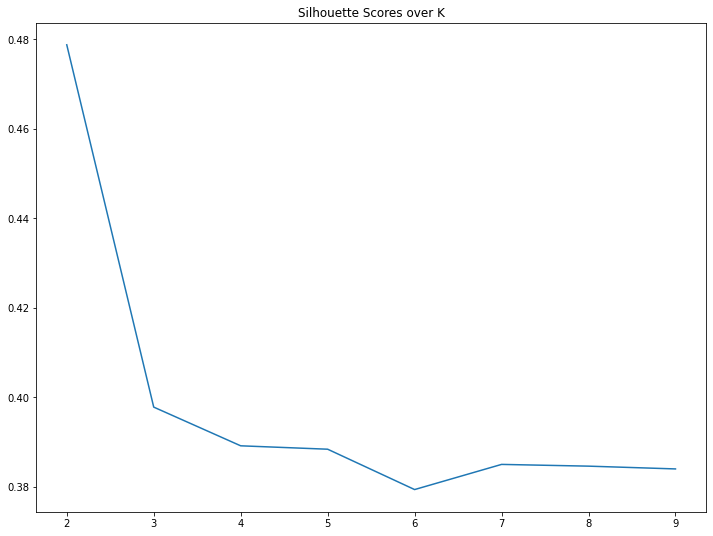

In [21]:
plot_sil_score(X_tsne_sc)

In [22]:
# plotting the inertia scores across k's
# Using the 'elbow' method to help find a good k
# https://medium.com/@cmukesh8688/k-means-clustering-in-machine-learning-252130c85e23

def plot_inertia_score(X_choice):
  
    # looking at multiple silhouette scores

  # set up empty list to store scores
  scores_ine = []

  for k in range(2, 10):
      # instantiate model
      km = KMeans(n_clusters=k, random_state=516)

      # fit the model
      km.fit(X_choice)

      # Get inertia score for each k
      scores_ine.append([k, km.inertia_])

  # save as a df for viewing
  scores_df = pd.DataFrame(scores_ine, columns = ['k', 'inertia'])

  plt.figure(figsize=(12,9))

  plt.plot(scores_df['k'], scores_df['inertia'])

  plt.title(f'Inertia Scores over K')

  plt.show()

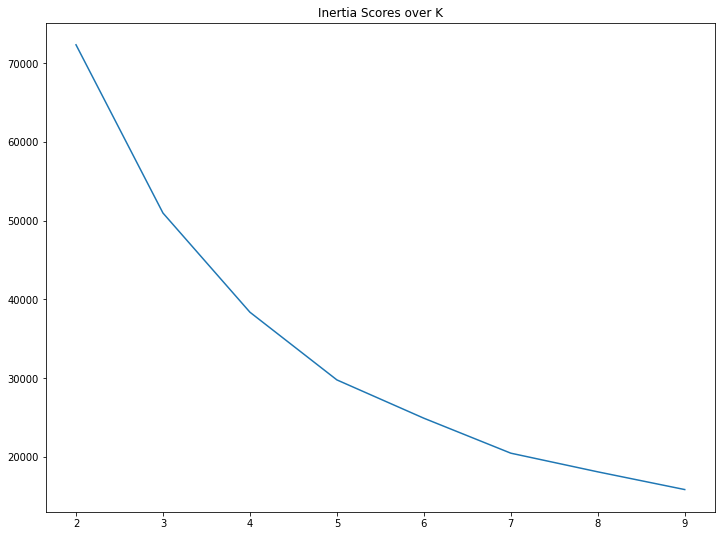

In [23]:
plot_inertia_score(X_tsne_sc)

In [24]:
# from sklearn.cluster import KMeans
def plot_k_clusters(k, X_choice):
  km = KMeans(n_clusters=k, random_state=516)
  km.fit(X_choice)
  km_means = km.predict(X_choice)

  plt.figure(figsize=(12,8))

  plt.scatter([X_choice[:, 0]], [X_choice[:, 1]], c=km_means, s=25, cmap='crest')

  centers = km.cluster_centers_
  plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5)

  plt.title(f'Clusters and Centroids:\n k = {k}', size=20)
  plt.show()

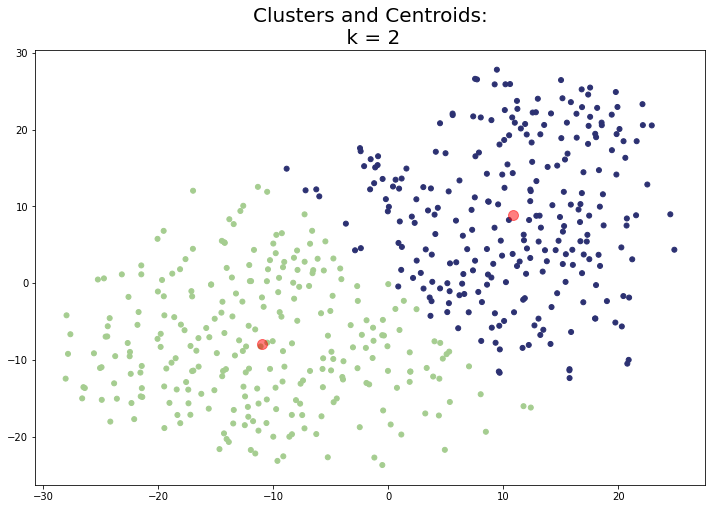

In [25]:
plot_k_clusters(2, X_tsne_sc)

In [26]:
# Based on above information, fit model w/ info
# from model w/ best silhouette & inertia scores to get labels
# add cluster labels to dataframe

km = KMeans(n_clusters = 2, random_state=516)

km.fit(X_tsne_sc)

print(set(km.labels_))

print(silhouette_score(X_tsne_sc, km.labels_))

print('--------------------')

data['km_label'] = km.labels_

print(data['km_label'].value_counts())

print('--------------------')

# print(km.cluster_centers_)

# adding km labels back on the dataframe
data['km_label'] = km.labels_

{0, 1}
0.47880247
--------------------
0    263
1    258
Name: km_label, dtype: int64
--------------------


In [27]:
# Function Using KNN to help find a good epsilon score
# to be used with DBSCAN
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

def find_epsilon(X_choice, knn_n):

  k_neighbors = NearestNeighbors(n_neighbors=knn_n)

  k_nbrs = k_neighbors.fit(X_choice)

  distances, indices = k_nbrs.kneighbors(X_choice)

  distances = np.sort(distances, axis=0)

  distances = distances[:,1]

  plt.figure(figsize=(12,8))

  plt.plot(distances)

  plt.title(f'Using KNN to Help Find Epsilon Score\n knn: {knn_n}', size=20)

  plt.show()

In [28]:
# Function to find silhouette score for DBSCAN using the epsilon
# fount from the graphs (elbow test)
# min_samples is set to natural log of number of points to be clustered
# HELP: https://askdatascience.com/646/dbscan-algorithm-how-should-choose-optimal-minimum-points
# HELP: https://moonbooks.org/Articles/How-to-calculate-the-natural-logarithm-in-python-/

def find_scores_db(X_choice, eps_value):

  dbscan = DBSCAN(eps=eps_value, min_samples=np.log(len(data))) #change the epsilon

  dbscan.fit(X_choice)

  print(set(dbscan.labels_))

  print(silhouette_score(X, dbscan.labels_))

  print('--------------------')

  data['dbscan_label'] = dbscan.labels_

  print(data['dbscan_label'].value_counts())

  print('--------------------')


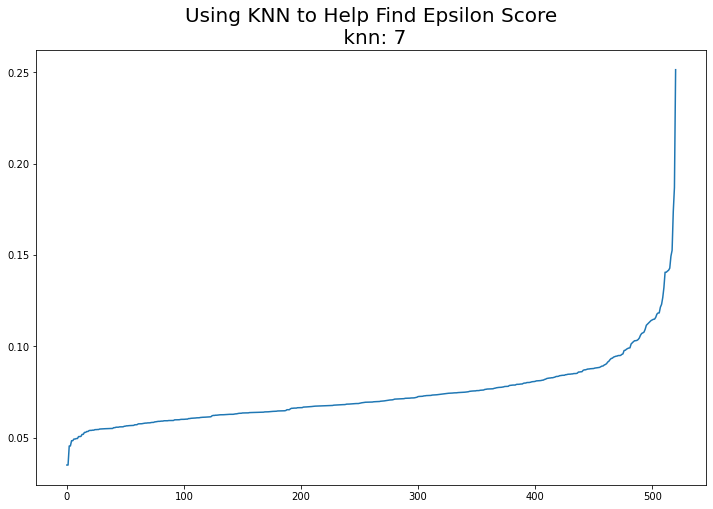

In [29]:
find_epsilon(X, 7)

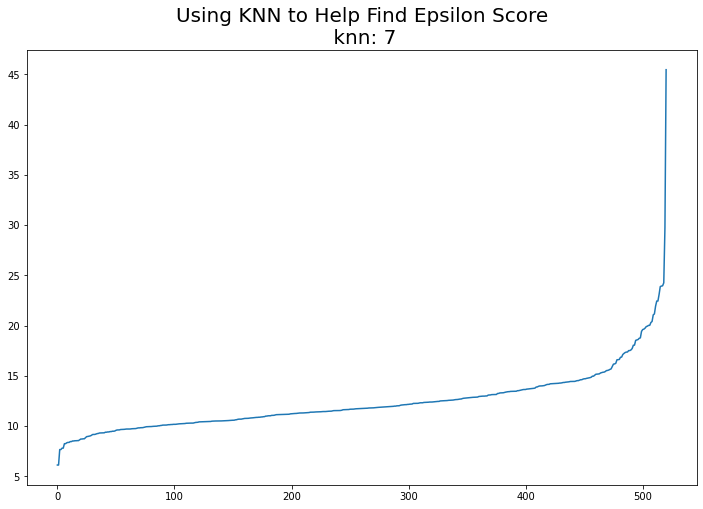

In [30]:
find_epsilon(X_sc, 7)

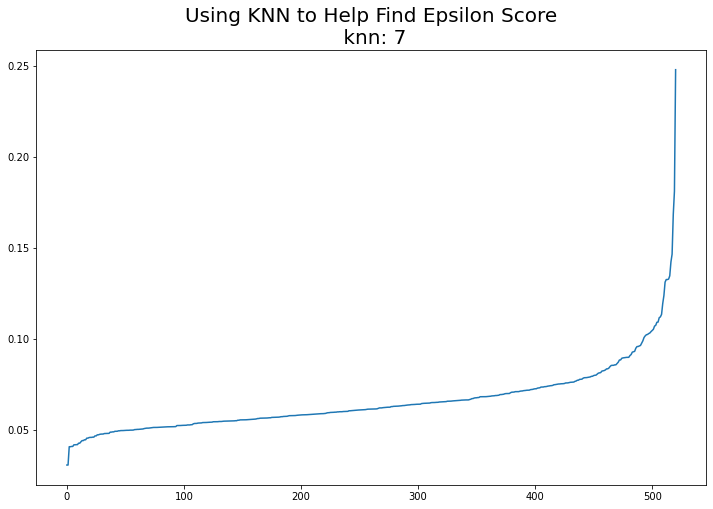

In [31]:
find_epsilon(X_pca, 7)

In [32]:
find_scores_db(X_pca, 0.11)

{0, -1}
0.4268770363886056
--------------------
 0    506
-1     15
Name: dbscan_label, dtype: int64
--------------------


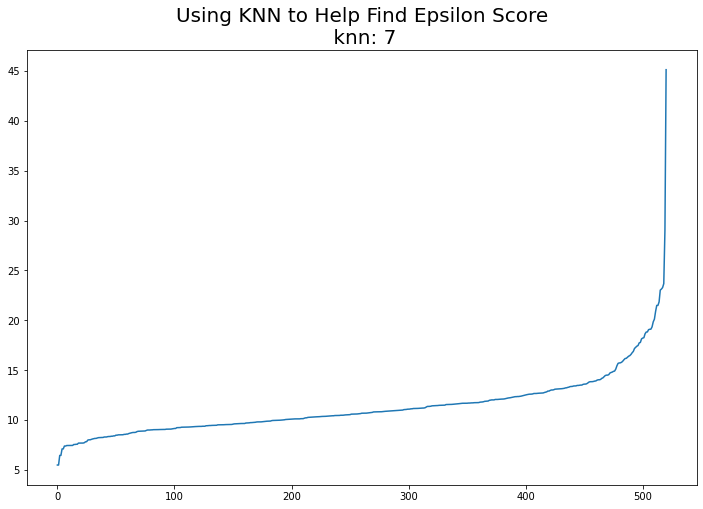

In [33]:
find_epsilon(X_pca_sc, 7)

In [34]:
find_scores_db(X_pca_sc, 20)

{0, -1}
0.46572057601623346
--------------------
 0    510
-1     11
Name: dbscan_label, dtype: int64
--------------------


##CVEC and TF-IDF

In [35]:
# Create X
X_ = data['liststring']
# X_ = np.matrix(X_.tolist())

In [36]:
X_.shape

(521,)

In [37]:
cvec = CountVectorizer(max_features = 250, ngram_range = (1, 1))


# tvec = TfidfVectorizer(max_df = .80, min_df = 10, max_features = 200, ngram_range = (1, 2))
tvec = TfidfVectorizer(max_features = 200, ngram_range = (1, 1))



In [38]:
X_c = pd.DataFrame(cvec.fit_transform(X_).toarray(), columns = cvec.get_feature_names())

X_t = pd.DataFrame(tvec.fit_transform(X_).toarray(), columns = tvec.get_feature_names())

In [39]:
# # Create X
# X = data['vectors']
# X = np.matrix(X.tolist())

# Applying the Standard Scaler to word vectors
sc = StandardScaler()
X_sc_c = sc.fit_transform(X_c)
X_sc_t = sc.fit_transform(X_t)

# Applying PCA to word vectors
pca = PCA(n_components = 0.95)
X_pca_c = pca.fit_transform(X_c)
X_pca_t = pca.fit_transform(X_t)

# Applying standard scaler, then applying PCA to word vectors
pca_sc = PCA(n_components = 0.95)
X_pca_sc_c = pca_sc.fit_transform(X_sc_c)
X_pca_sc_t = pca_sc.fit_transform(X_sc_t)

# TSNE w/ scaled data
tsne = TSNE(n_components=2)
# X_tsne = tsne.fit_transform(X)
X_tsne_c = tsne.fit_transform(X_c)
X_tsne_t = tsne.fit_transform(X_t)

X_tsne_sc_c = tsne.fit_transform(X_pca_c)
X_tsne_sc_t = tsne.fit_transform(X_pca_t)

# TSNE w/ scaled data
tsne = TSNE(n_components=2)
# X_tsne_sc = tsne.fit_transform(X_sc)
X_tsne_pca_c = tsne.fit_transform(X_pca_c)
X_tsne_pca_t = tsne.fit_transform(X_pca_t)

X_tsne_pca_sc_c = tsne.fit_transform(X_pca_sc_c)
X_tsne_pca_sc_t = tsne.fit_transform(X_pca_sc_t)

In [40]:
find_scores_k(X_c)

,k,silhouette,inertia
0,2,0.506212,4.701210e+08
1,3,0.399271,3.680191e+08
2,4,0.316501,3.216538e+08
3,5,0.302238,2.996552e+08
4,6,0.281498,2.825113e+08
5,7,0.281057,2.642791e+08
6,8,0.210064,2.526450e+08
7,9,0.201986,2.398323e+08


In [41]:
find_scores_k(X_sc_c)

,k,silhouette,inertia
0,2,0.464234,83403.035187
1,3,0.367641,67739.745546
2,4,0.292690,59018.860248
3,5,0.245528,55490.055286
4,6,0.215860,53010.416973
5,7,0.208334,50726.182829
6,8,0.133588,49083.352287
7,9,0.131501,47864.761411


In [42]:
find_scores_k(X_pca_c)

,k,silhouette,inertia
0,2,0.524990,4.339890e+08
1,3,0.423834,3.319910e+08
2,4,0.344426,2.857006e+08
3,5,0.324399,2.637613e+08
4,6,0.310452,2.470744e+08
5,7,0.310787,2.284859e+08
6,8,0.263444,2.165738e+08
7,9,0.218945,2.050507e+08


In [43]:
find_scores_k(X_pca_sc_c)

,k,silhouette,inertia
0,2,0.482040,77004.589223
1,3,0.396119,61358.780286
2,4,0.317108,52629.306757
3,5,0.259426,49030.839475
4,6,0.229910,46545.548505
5,7,0.179070,44454.659746
6,8,0.180483,43003.130316
7,9,0.145201,41162.323867


In [44]:
find_scores_k(X_tsne_c)

,k,silhouette,inertia
0,2,0.563876,60539.743444
1,3,0.489385,35404.862359
2,4,0.434873,24380.595301
3,5,0.404784,19351.427829
4,6,0.433682,15516.019762
5,7,0.420313,13196.065353
6,8,0.415181,11122.052775
7,9,0.411055,9803.026114


In [45]:
find_scores_k(X_tsne_sc_c)

,k,silhouette,inertia
0,2,0.539357,153116.346721
1,3,0.503553,80478.689155
2,4,0.440611,58126.783892
3,5,0.417384,48141.498613
4,6,0.414377,37874.982819
5,7,0.426665,31701.945442
6,8,0.410972,26585.256725
7,9,0.401783,23662.717507


In [46]:
find_scores_k(X_tsne_pca_c)

,k,silhouette,inertia
0,2,0.537732,154734.696176
1,3,0.494432,83111.286180
2,4,0.437761,59796.298717
3,5,0.405785,48898.328571
4,6,0.408852,38604.652725
5,7,0.391997,32926.712565
6,8,0.396827,28125.629784
7,9,0.384184,25167.175910


In [47]:
find_scores_k(X_tsne_pca_sc_c)

,k,silhouette,inertia
0,2,0.557598,51398.160909
1,3,0.492036,29261.842550
2,4,0.426082,21174.259715
3,5,0.438241,17078.798771
4,6,0.414114,13528.428266
5,7,0.407899,11260.619197
6,8,0.404146,9645.103195
7,9,0.406976,8371.261947


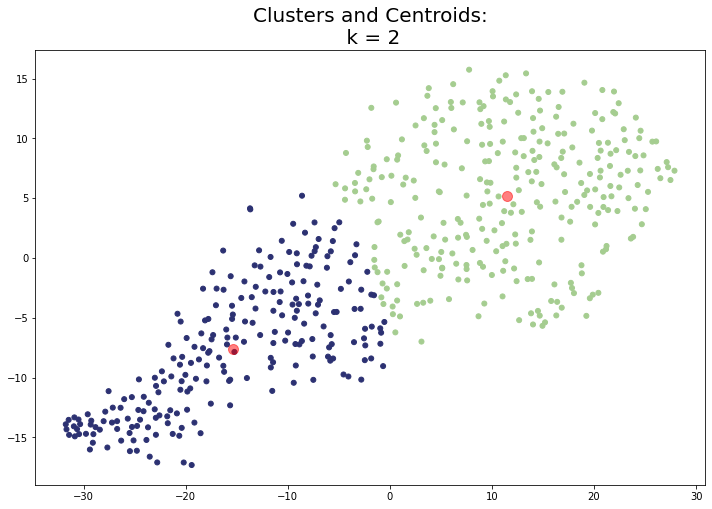

In [48]:
plot_k_clusters(2, X_tsne_pca_sc_c)

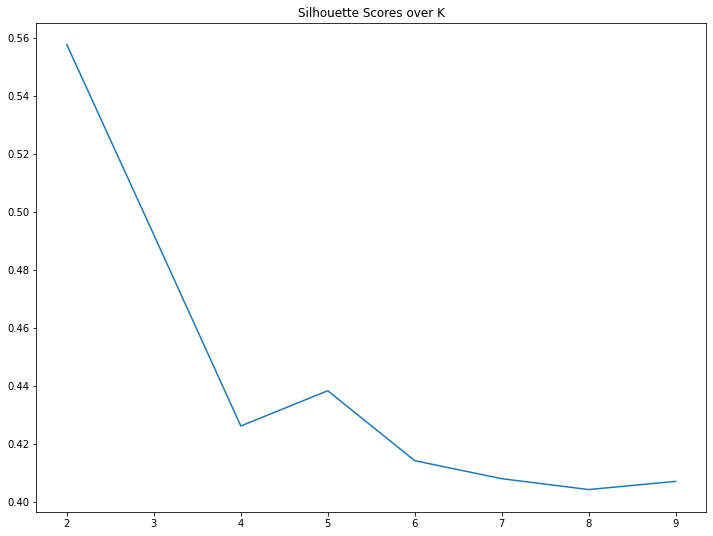

In [49]:
plot_sil_score(X_tsne_pca_sc_c)

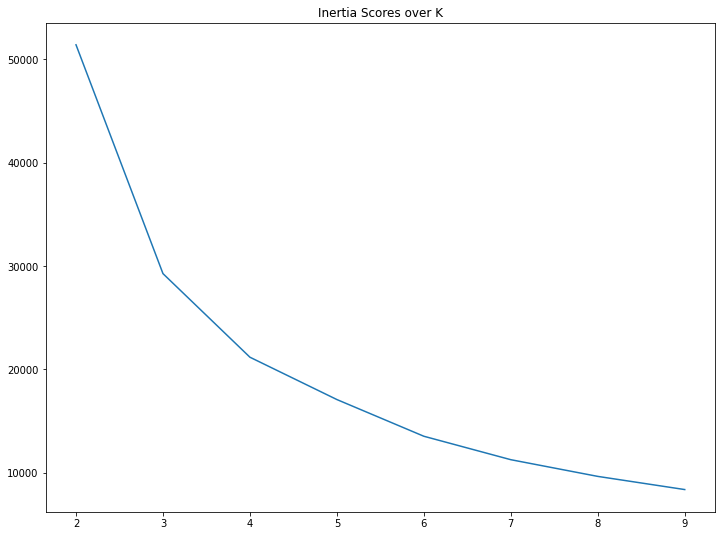

In [50]:
plot_inertia_score(X_tsne_pca_sc_c)

In [51]:
find_scores_k(X_t)

,k,silhouette,inertia
0,2,0.118171,94.644079
1,3,0.108976,87.871240
2,4,0.080054,83.518805
3,5,0.084171,80.779474
4,6,0.064979,78.904075
5,7,0.060561,77.701454
6,8,0.056634,76.410285
7,9,0.056971,75.026443


In [52]:
find_scores_k(X_sc_t)

,k,silhouette,inertia
0,2,0.085987,94800.494951
1,3,0.070616,89721.615214
2,4,0.053444,87265.780918
3,5,0.045029,85366.426863
4,6,0.035050,84203.672318
5,7,0.032154,82865.659601
6,8,0.045450,82001.879143
7,9,0.033265,80707.751547


In [53]:
find_scores_k(X_pca_t)

,k,silhouette,inertia
0,2,0.124651,89.288831
1,3,0.120076,82.436943
2,4,0.085710,78.167313
3,5,0.085884,75.438487
4,6,0.068866,73.561616
5,7,0.064269,72.039945
6,8,0.060737,70.833391
7,9,0.048452,69.989813


In [54]:
find_scores_k(X_pca_sc_t)

,k,silhouette,inertia
0,2,0.090810,89661.227796
1,3,0.075133,84587.201210
2,4,0.056481,82131.774507
3,5,0.044083,80293.605405
4,6,0.036225,79047.113703
5,7,0.047083,77713.096867
6,8,0.036590,76328.848728
7,9,0.036538,75561.327441


In [55]:
find_scores_k(X_tsne_t)

,k,silhouette,inertia
0,2,0.478951,45358.353033
1,3,0.452602,26878.562239
2,4,0.449776,18230.625629
3,5,0.411236,14483.157857
4,6,0.403367,12532.909839
5,7,0.384459,11072.051418
6,8,0.362969,9744.191484
7,9,0.362719,8503.154499


In [56]:
find_scores_k(X_tsne_sc_t)

,k,silhouette,inertia
0,2,0.480484,42705.370006
1,3,0.449181,26340.453211
2,4,0.448171,17690.001063
3,5,0.414597,13966.284770
4,6,0.395326,12322.918301
5,7,0.374065,10813.825073
6,8,0.374623,9476.544569
7,9,0.365911,8370.238403


In [57]:
find_scores_k(X_tsne_pca_t)

,k,silhouette,inertia
0,2,0.461925,46321.946952
1,3,0.461597,26737.140063
2,4,0.445229,18528.744590
3,5,0.410167,14750.426433
4,6,0.399424,12820.161212
5,7,0.376621,11119.755563
6,8,0.357967,9954.554729
7,9,0.370860,8929.761261


In [58]:
find_scores_k(X_tsne_pca_sc_t)

,k,silhouette,inertia
0,2,0.402640,43207.202981
1,3,0.417009,27107.408818
2,4,0.403638,18682.218916
3,5,0.383640,14445.414598
4,6,0.357258,12262.921299
5,7,0.348634,10706.982641
6,8,0.359294,9278.810651
7,9,0.362446,7981.791957


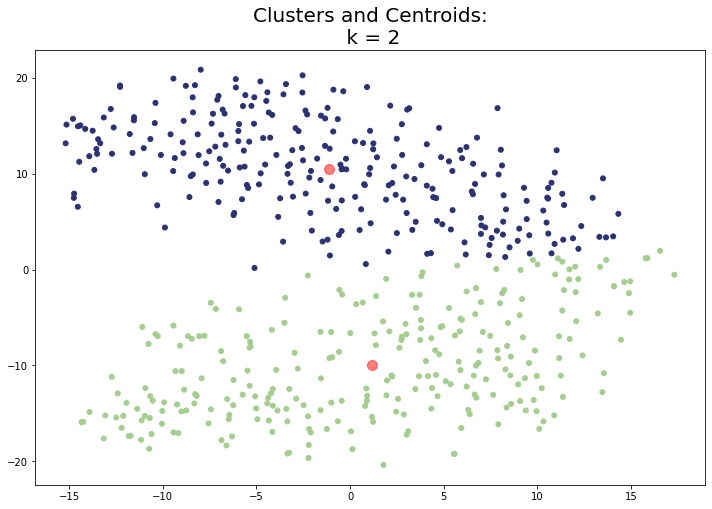

In [59]:
plot_k_clusters(2, X_tsne_t)

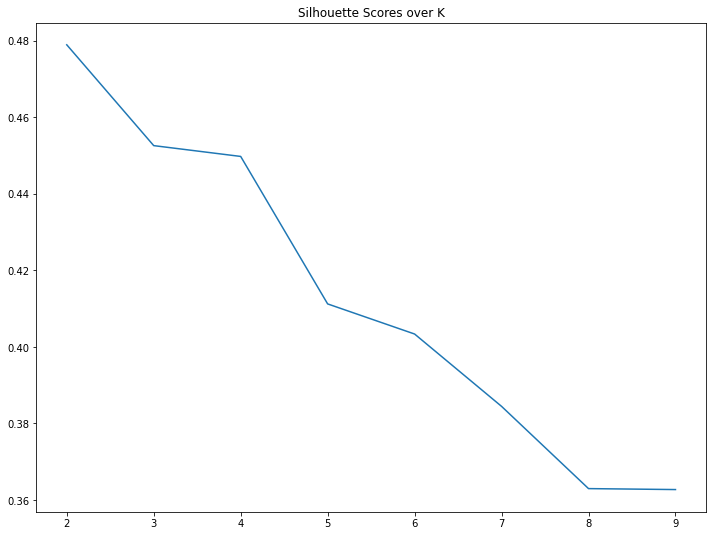

In [60]:
plot_sil_score(X_tsne_t)

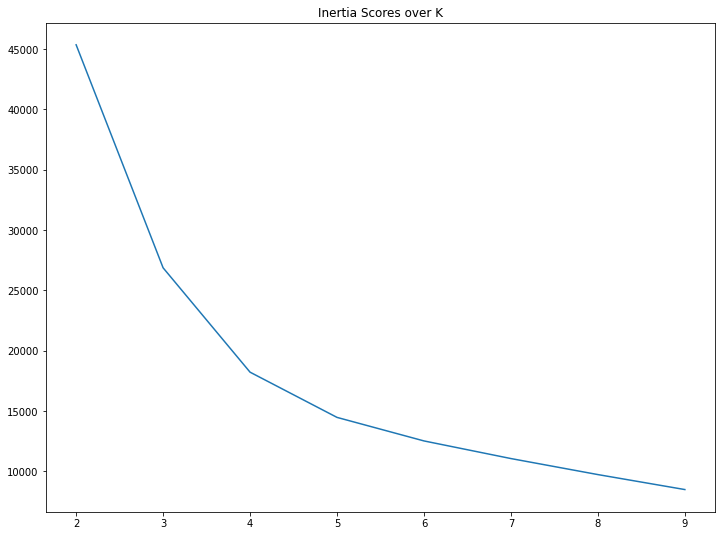

In [61]:
plot_inertia_score(X_tsne_t)

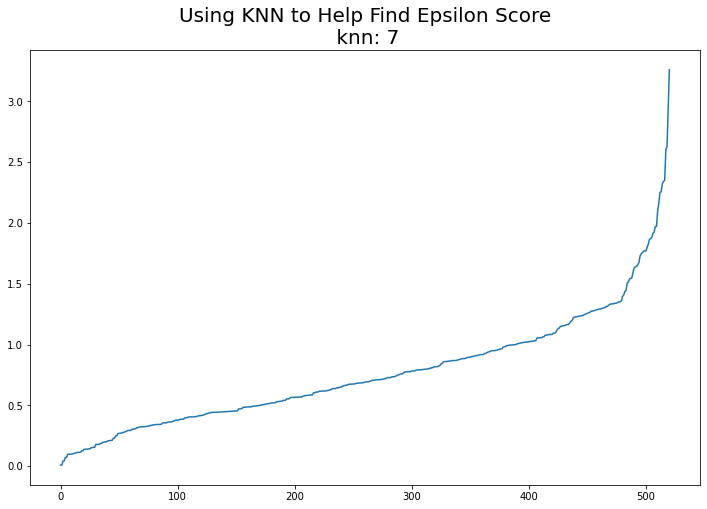

In [62]:
find_epsilon(X_tsne_t, 7)

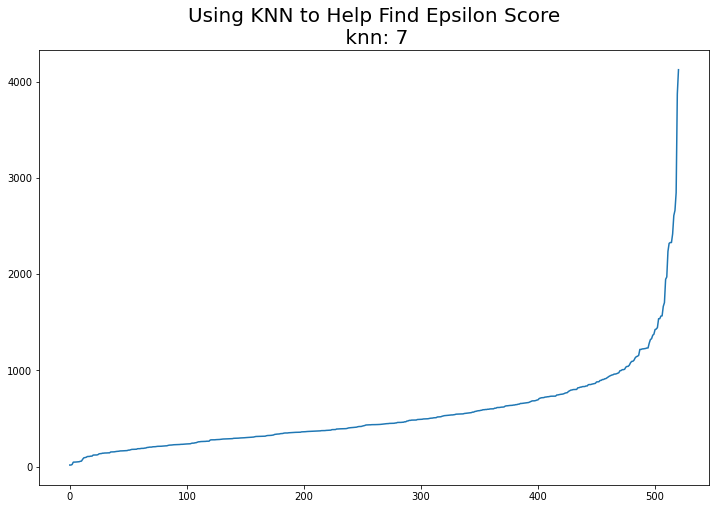

In [63]:
find_epsilon(X_c, 7)

In [64]:
find_scores_db(X_tsne_t, 1.4)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}
-0.16603435281702267
--------------------
-1     320
 0      39
 2      29
 6      22
 9      18
 7      18
 4      16
 5      13
 10     10
 8       9
 3       9
 11      8
 1       6
 12      4
Name: dbscan_label, dtype: int64
--------------------


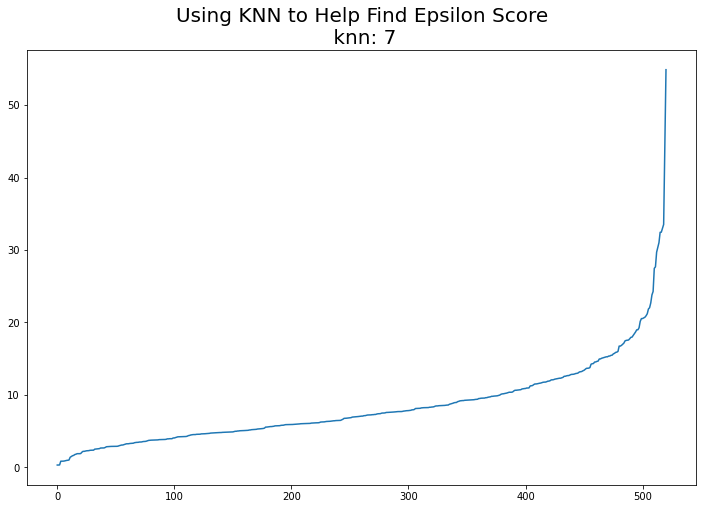

In [65]:
find_epsilon(X_sc_c, 7)

In [66]:
find_scores_db(X_sc_c, 18)

{0, -1}
0.07335318630924256
--------------------
 0    489
-1     32
Name: dbscan_label, dtype: int64
--------------------


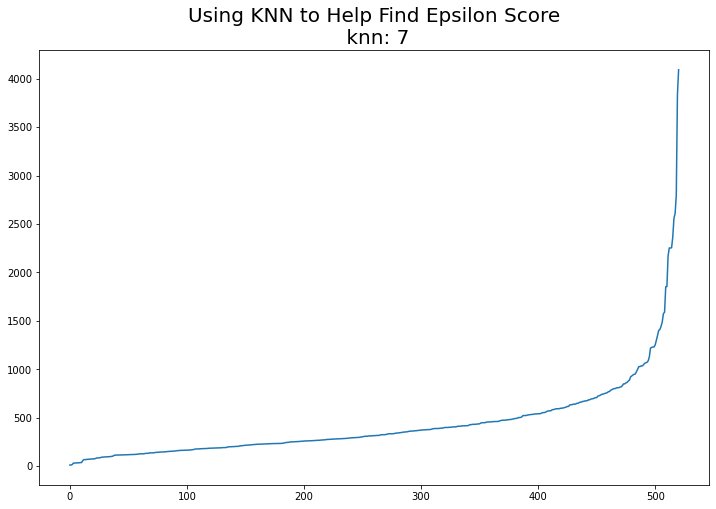

In [67]:
find_epsilon(X_pca_c, 7)

In [68]:
find_scores_db(X_pca_c, 1500)

{0, -1}
0.05968682029016115
--------------------
 0    507
-1     14
Name: dbscan_label, dtype: int64
--------------------


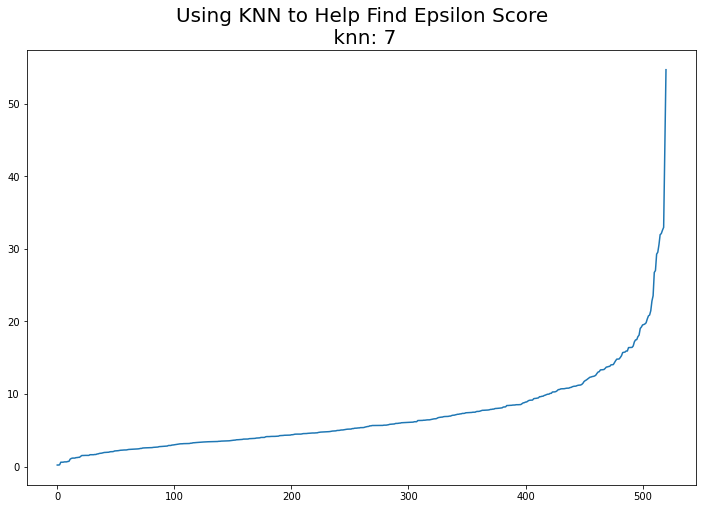

In [69]:
find_epsilon(X_pca_sc_c, 7)

In [70]:
find_scores_db(X_pca_sc_c, 18)

{0, -1}
0.08055669457762471
--------------------
 0    497
-1     24
Name: dbscan_label, dtype: int64
--------------------


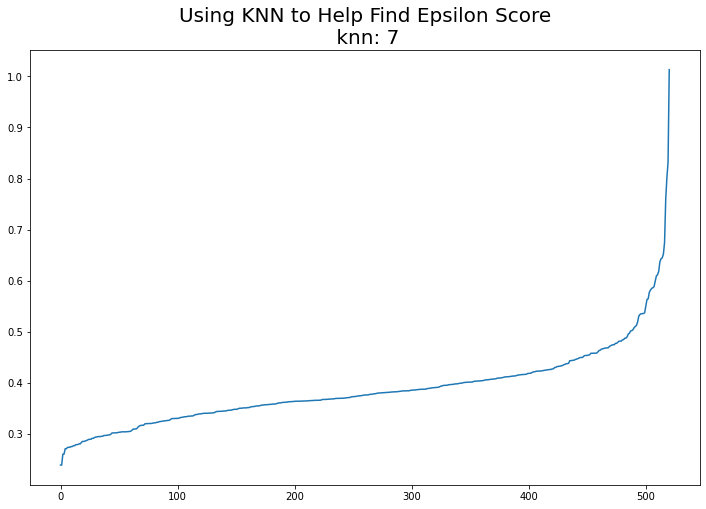

In [71]:
find_epsilon(X_t, 7)

In [72]:
find_scores_db(X_t, 0.5)

{0, -1}
0.20969538941996518
--------------------
 0    486
-1     35
Name: dbscan_label, dtype: int64
--------------------


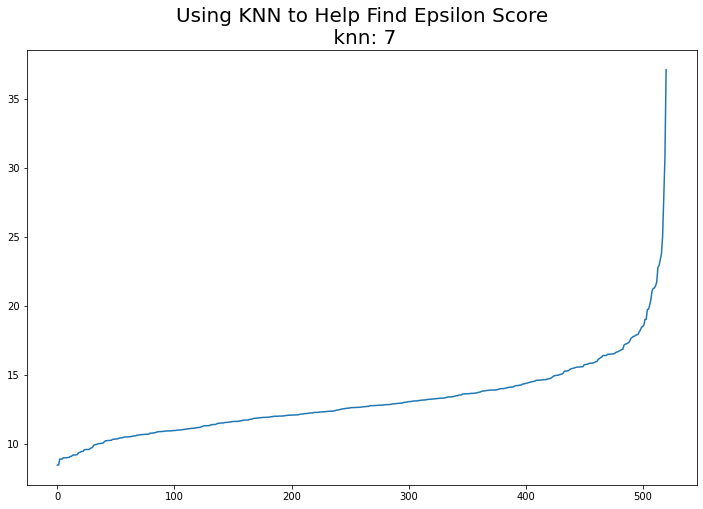

In [73]:
find_epsilon(X_sc_t, 7)

In [74]:
find_scores_db(X_sc_t, 18)

{0, -1}
0.244243238022162
--------------------
 0    497
-1     24
Name: dbscan_label, dtype: int64
--------------------


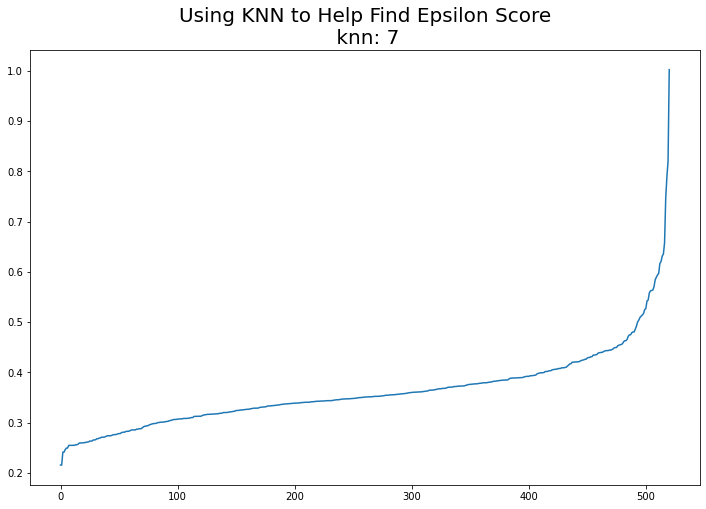

In [75]:
find_epsilon(X_pca_t, 7)

In [76]:
find_scores_db(X_pca_t, 0.45)

{0, -1}
0.1783601391352314
--------------------
 0    473
-1     48
Name: dbscan_label, dtype: int64
--------------------


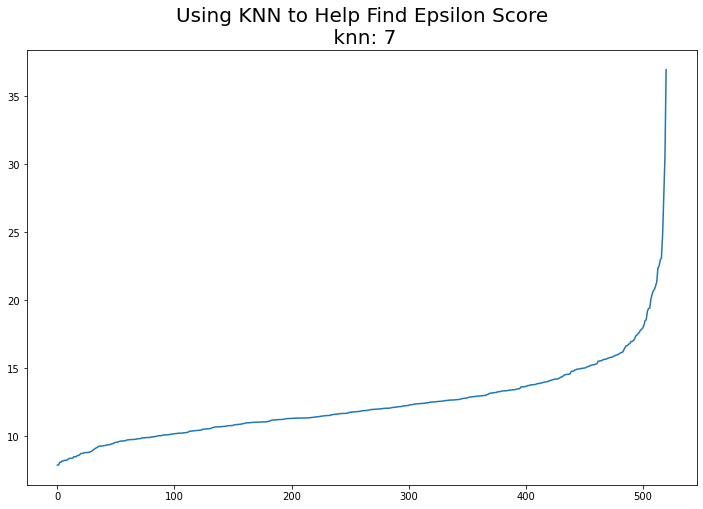

In [77]:
find_epsilon(X_pca_sc_t, 7)

In [78]:
# find_scores_db(X_tsne_sc_t, 17)

In [79]:
# Get the cosine similarity for each document
# Help from Kelly Slatery
# Looking at the first 50 documents
vector_distances = pd.DataFrame(pairwise_distances(X_tsne_c[:50], X_tsne_c[:50], metric='cosine'))
vector_distances.corr().head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1.000000,0.999807,0.919520,0.999882,0.992291,0.994439,0.932681,0.977139,0.997473,0.991800,0.985543,0.996379,0.993035,0.949074,0.943174,0.967399,0.999550,0.883059,0.746799,0.999973,-0.741631,0.922890,0.910634,0.986266,0.991048,0.999242,0.687026,0.643877,-0.930789,0.988448,0.991194,0.999479,0.913401,0.976477,0.998944,0.999184,-0.965838,0.622979,0.990424,-0.539077,-0.830466,0.749814,-0.916962,0.998562,-0.970183,1.000000,0.999910,0.738552,-0.997329,-0.997994
1,0.999807,1.000000,0.911621,0.999991,0.994534,0.992178,0.939587,0.981127,0.998676,0.994119,0.988681,0.997857,0.995158,0.955081,0.949520,0.972188,0.998768,0.892107,0.759720,0.999925,-0.754666,0.930277,0.902341,0.989320,0.993480,0.999814,0.701169,0.628721,-0.937791,0.991234,0.993604,0.999920,0.921222,0.972053,0.999654,0.998197,-0.970743,0.638226,0.987520,-0.522426,-0.819361,0.762668,-0.924623,0.997316,-0.974757,0.999804,0.999453,0.751654,-0.998572,-0.996557
2,0.919520,0.911621,1.000000,0.913385,0.863722,0.955799,0.715847,0.814938,0.889272,0.861749,0.839635,0.882772,0.866805,0.748863,0.736658,0.790002,0.930897,0.627549,0.425303,0.916589,-0.418287,0.697269,0.999757,0.841974,0.858816,0.903518,0.346136,0.892786,-0.712199,0.849326,0.859376,0.906355,0.679898,0.982638,0.900492,0.934649,-0.786251,0.265387,0.964978,-0.826736,-0.982582,0.429412,-0.686350,0.939271,-0.796838,0.919578,0.924715,0.414124,-0.888356,-0.942560
3,0.999882,0.999991,0.913385,1.000000,0.994075,0.992708,0.938102,0.980284,0.998445,0.993643,0.988025,0.997565,0.994724,0.953793,0.948158,0.971169,0.998972,0.890150,0.756908,0.999968,-0.751829,0.928686,0.904192,0.988683,0.992979,0.999721,0.698087,0.632069,-0.936285,0.990655,0.993108,0.999856,0.919535,0.973056,0.999531,0.998447,-0.969698,0.634899,0.988191,-0.526099,-0.821826,0.759871,-0.922972,0.997622,-0.973785,0.999880,0.999586,0.748802,-0.998332,-0.996906
4,0.992291,0.994534,0.863722,0.994075,1.000000,0.973722,0.970193,0.995954,0.998588,0.999992,0.998942,0.999235,0.999981,0.980802,0.977084,0.991327,0.988127,0.934407,0.823461,0.993180,-0.819046,0.963496,0.852405,0.999132,0.999953,0.996364,0.771781,0.544091,-0.968917,0.999611,0.999963,0.995774,0.956807,0.942228,0.996937,0.986474,-0.990508,0.715118,0.965679,-0.430541,-0.755026,0.826031,-0.959338,0.984219,-0.992741,0.992273,0.990537,0.816411,-0.998692,-0.982454


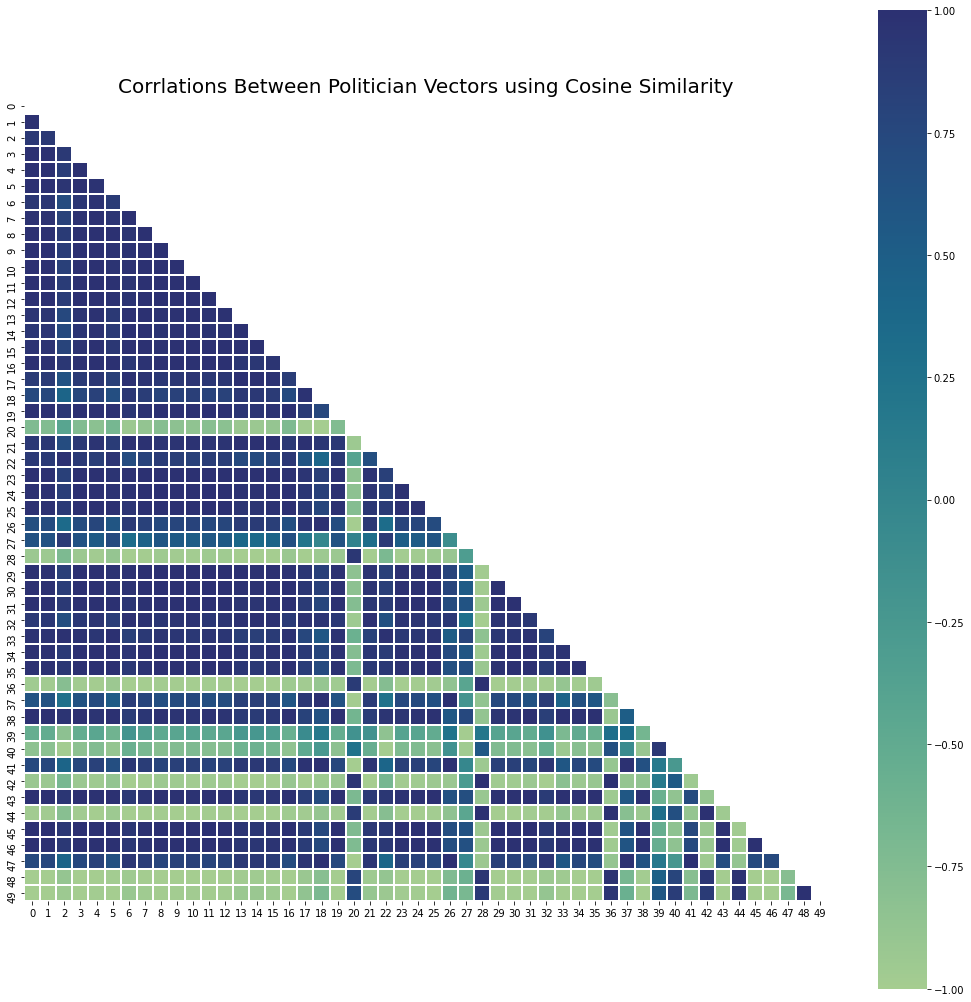

In [80]:
# Seeing correlations between first 50 documents (dataset is too large with all documents) using cosine similarity
plt.figure(figsize=(18,18))

corr = vector_distances.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, 
            cmap='crest', 
            vmax=1, 
            vmin=-1, 
            linecolor='white', 
            linewidths=1,
            square=True, 
           mask=mask)

plt.title('Corrlations Between Politician Vectors using Cosine Similarity', size=20)

plt.show()

In [82]:
# count the most frequently occuring words 

# dictionary to hold column header, count (key, value)
freq_words = {}

# loop through columns
for col in X_c.columns:
    
    # save sum of each column in dictionary
    freq_words[col] = X_c[col].sum()  
    
# save dictionary words in a dataframe
most_common = pd.DataFrame(sorted(freq_words.items(), key = lambda x: x[1], reverse = True))

most_common[:20]


,0,1
0,today,136868
1,work,128641
2,need,115104
3,trump,100434
4,help,100053
5,people,92826
6,act,92378
7,president,91200
8,thank,89566
9,community,88413


In [83]:
# CVEC

# Based on above information, fit model w/ info
# from model w/ best silhouette & inertia scores to get labels
# add cluster labels to dataframe

km = KMeans(n_clusters=2, random_state=516)
km.fit(X_tsne_pca_sc_c)
km_means = km.predict(X_tsne_pca_sc_c)

print(set(km.labels_))

print(silhouette_score(X_tsne_pca_sc_c, km.labels_))

print('--------------------')

data['km_label_cvec'] = km.labels_

print(data['km_label_cvec'].value_counts())

print('--------------------')


{0, 1}
0.5575985
--------------------
0    292
1    229
Name: km_label_cvec, dtype: int64
--------------------


In [84]:
# TVEC

# Based on above information, fit model w/ info
# from model w/ best silhouette & inertia scores to get labels
# add cluster labels to dataframe

km = KMeans(n_clusters=2, random_state=516)
km.fit(X_tsne_t)
km_means = km.predict(X_tsne_t)

print(set(km.labels_))

print(silhouette_score(X_tsne_t, km.labels_))

print('--------------------')

data['km_label_tvec'] = km.labels_

print(data['km_label_tvec'].value_counts())

print('--------------------')

{0, 1}
0.47895053
--------------------
0    262
1    259
Name: km_label_tvec, dtype: int64
--------------------


In [85]:
data.head(2)

,screen_name,state,position,name,party,tweet_count,text_concat_clean,liststring,vectors,text_length,word_length,km_label,dbscan_label,km_label_cvec,km_label_tvec
0,CongressmanRaja,IL,Representative,Raja Krishnamoorthi,D,4845,"['tonight', 'president', 'stage', 'elaborate',...",'tonight' 'president' 'stage' 'elaborate' 'pho...,"[-0.2115751579, 0.39771672760000004, 0.0444499...",1623390,178283,1,0,0,1
1,RepMcGovern,MA,Representative,James McGovern,D,3587,"['hell', 'Donald', 'Trump', 'think', 'teargass...",'hell' 'Donald' 'Trump' 'think' 'teargasse' 'p...,"[-0.20878361280000002, 0.39065130130000003, 0....",1313476,154634,1,0,0,1


In [87]:

# # # # Export dataframe with kmeans and dbscan labels
# # # data.to_csv('./data/vectors_labels_df.csv', index=False)

# Exporting in google colab. Update directory as needed.
data.to_csv('/content/drive/MyDrive/Python/vectors_labels_df.csv', index=False)
